<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

## Questions:
#Do I take the Conv output before or after ReLU

on device: cuda


In [4]:
# try:
#   import einops
# except:
#   !pip install einops
# from einops import rearrange, reduce, repeat

# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

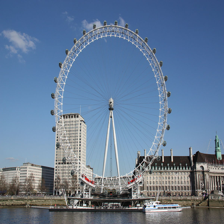

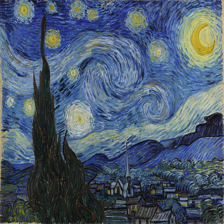

In [5]:
content_image = Image.open("/content/LondonEye.jpg").resize((224, 224))
content_image.show()
style_image = Image.open("/content/StarryNight.jpg").resize((224, 224))
style_image.show()

In [6]:
content = torch.tensor(np.asarray(content_image)/255.).type(torch.float).permute(2, 0, 1).unsqueeze(dim=0).to(device)
style = torch.tensor(np.asarray(style_image)/255.).type(torch.float).permute(2, 0, 1).unsqueeze(dim=0).to(device)
content.shape, style.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [7]:
weights = torchvision.models.VGG19_Weights.IMAGENET1K_V1 #  height=224, width=224
vgg_pretrained_model = torchvision.models.vgg19(weights=weights).to(device)

#Deleting end layers to reduce model computational overhead
for i in range(29, 37): vgg_pretrained_model.features[i] = nn.Sequential()
vgg_pretrained_model.avgpool = nn.Sequential()
vgg_pretrained_model.classifier = nn.Sequential()
# print(vgg_pretrained_model)

#Register hook
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output #.detach()
    return hook

output_idxs = [0, 5, 10, 19, 28]
for conv_num, i in enumerate(output_idxs):
  vgg_pretrained_model.features[i].register_forward_hook(get_activation('conv'+str(conv_num+1)))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [36]:
class NeuralStyleTransfer(nn.Module):
  def __init__(self, vgg_model, generated_size=(1, 3, 224, 224)):
    super().__init__()

    self.generated = nn.Parameter(torch.rand(generated_size))
    self.vgg = vgg_model

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.vgg(self.generated)

def calculate_loss(activations, content_layer_idx = 0, style_layers_to_use=1):
  """Calculates content and style loss

  activations (dict of torch.Tensor's) --outputs from the immediate layers in the network for content, style & generated images
  content_layer_idx (int 0-4) --layer index to use for context features
  
  Returns content and style loss, (torch.Tensor with grad)
  """
  # for key in activations: print(key, activations[key].shape)
  loss_fn = nn.MSELoss(reduction='sum') # as described in paper

  content_outputs = []
  style_outputs = []
  generated_outputs = []
  for key in activations:
    content_outputs.append(activations[key][0])
    style_outputs.append(activations[key][1])
    generated_outputs.append(activations[key][2])

  # possibly flatten first (for clarity, although I don't think it will change the output)
  c = torch.flatten(content_outputs[content_layer_idx], start_dim=1,end_dim=2) #torch.Size([64, 50176])
  g = torch.flatten(generated_outputs[content_layer_idx], start_dim=1,end_dim=2)
  content_loss = (1/2)*loss_fn(c, g) #* 1/()


  style_layer_weights = [1/style_layers_to_use for _ in range(style_layers_to_use)]
  for i in range(style_layers_to_use):
    #Create Gram matrix for Style and generated Image
    s = torch.flatten(style_outputs[i], start_dim=1,end_dim=2) # 'c h w -> c (h w)
    g = torch.flatten(generated_outputs[i], start_dim=1,end_dim=2)

    scale_factor = 1/((2*s.shape[0]*s.shape[1])**2) #1/(4N_l^2M_l^2)
    style_loss = scale_factor*loss_fn(s@s.T, g@g.T)
    # layer_loss = loss_fn(s@s.T, g@g.T) # (c c)
    # style_loss+= scale_factor*layer_loss

  return content_loss, style_loss

In [37]:
### Inputs & Hyperparameters
alpha = 0.01
beta = 100000000

learning_rate = 3e-3
epochs = 5000

model = NeuralStyleTransfer(vgg_pretrained_model).to(device)
optimizer = torch.optim.SGD([model.generated], lr=learning_rate)
model.train()
for epoch in range(epochs):   
  input = torch.concat((content, style, model.generated), dim=0)
  _ = vgg_pretrained_model(input)

  content_loss, style_loss = calculate_loss(activations, content_layer_idx=1, style_layers_to_use=1)
  loss = alpha*content_loss + beta*style_loss
  if epoch % 100 == 0: 
    print(f"\nEpoch: {epoch} | {loss.item():.4f}")
    print(f"loss: {loss.item():.4f} | content(alpha) contribution: {alpha*content_loss.item():.4f} | style(beta) contribution: {beta*style_loss.item():.7f}")

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


Epoch: 0 | 51786.6641
loss: 51786.6641 | content(alpha) contribution: 15726.1038 | style(beta) contribution: 36060.5568858

Epoch: 100 | 1655.9668
loss: 1655.9668 | content(alpha) contribution: 1292.8844 | style(beta) contribution: 363.0823358

Epoch: 200 | 816.6923
loss: 816.6923 | content(alpha) contribution: 568.8194 | style(beta) contribution: 247.8728902

Epoch: 300 | 606.7649
loss: 606.7649 | content(alpha) contribution: 396.6767 | style(beta) contribution: 210.0882057

Epoch: 400 | 505.6255
loss: 505.6255 | content(alpha) contribution: 320.7365 | style(beta) contribution: 184.8890633

Epoch: 500 | 442.9870
loss: 442.9870 | content(alpha) contribution: 276.4134 | style(beta) contribution: 166.5736136

Epoch: 600 | 400.2197
loss: 400.2197 | content(alpha) contribution: 246.8508 | style(beta) contribution: 153.3688874

Epoch: 700 | 368.8132
loss: 368.8132 | content(alpha) contribution: 225.1524 | style(beta) contribution: 143.6608386

Epoch: 800 | 345.4471
loss: 345.4471 | content

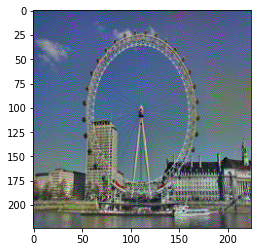

In [38]:
formatted_output = nn.functional.relu(model.generated.detach().cpu()[0].permute(1, 2, 0))
formatted_output[formatted_output > 1] = 1
plt.imshow(formatted_output)

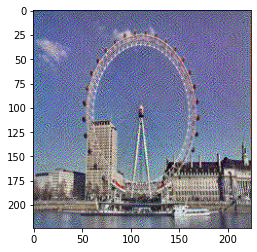

In [10]:
formatted_output = nn.functional.relu(model.generated.detach().cpu()[0].permute(1, 2, 0))
formatted_output[formatted_output > 1] = 1
plt.imshow(formatted_output)

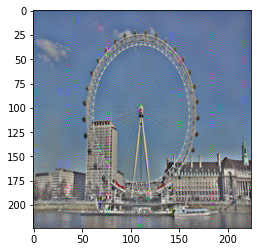

In [68]:
formatted_output = nn.functional.relu(model.generated.detach().cpu()[0].permute(1, 2, 0))
formatted_output[formatted_output > 1] = 1
plt.imshow(formatted_output)

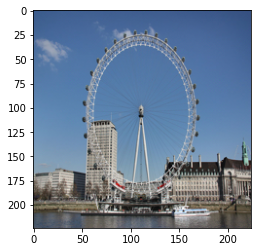

In [19]:
#conv1:
formatted_output = nn.functional.relu(model.generated.detach().cpu()[0].permute(1, 2, 0))
formatted_output[formatted_output > 1] = 1
plt.imshow(formatted_output)

In [ ]:
summary(vgg_pretrained_model, input_size=[1, 3, 224, 224], col_names =['input_size', 'output_size', 'num_params', 'trainable'])